### Datastream

###### 一、如何建立分区表用于传输
配置msql 中的binlog方式 参考文档：https://cloud.google.com/datastream/docs/configure-self-managed-mysql?hl=zh-cn

###### (一) 表已在传输中
谷歌参考文档地址：https://cloud.google.com/datastream/docs/best-practices-partitioned-tables?hl=zh-cn

1. datastream选中传输任务 修改**源配置**          
2. 展开高级选项 找到**选择要排除的对象** 见下图一                     
3. 按照格式要求输入实现排除表暂时不在传输 要求为：schema.*、schema.table、*.table、schema."table.1"    
   比如输入：**box_game_center.t_cash_order**  （box_game_center 为schema ；t_cash_order为table）       
4. 等待几分钟，确保 Datastream 已完成表的所有事件处理，即**表的缓冲区信息消失**，见下图二    
5. 创建**新的分区表 兼容datastream的流式传输** 建表语句见下面代码1    
   谷歌的参考文档：https://cloud.google.com/bigquery/docs/creating-partitioned-tables?hl=zh-cn    
6. 将原始表中的数据复制到新的分区表，目前暂时不明是否必须操作 手动回填，自动回填直接可能存在差别     
   且手动回填范围不确定 自动回填是否也做了自动去重 都是无法确定的     
7. 将新表的临时名称更改为原始表的名称，旧表直接删除     
8. 修改**源配置** 中 **选择要排除的对象** 去掉表 回复传输    

额外验证项目：     
如果已有表，你直接删除，自动回填模式下，会丢失部分数据，必须等旧表排空把旧表数据插入才行       

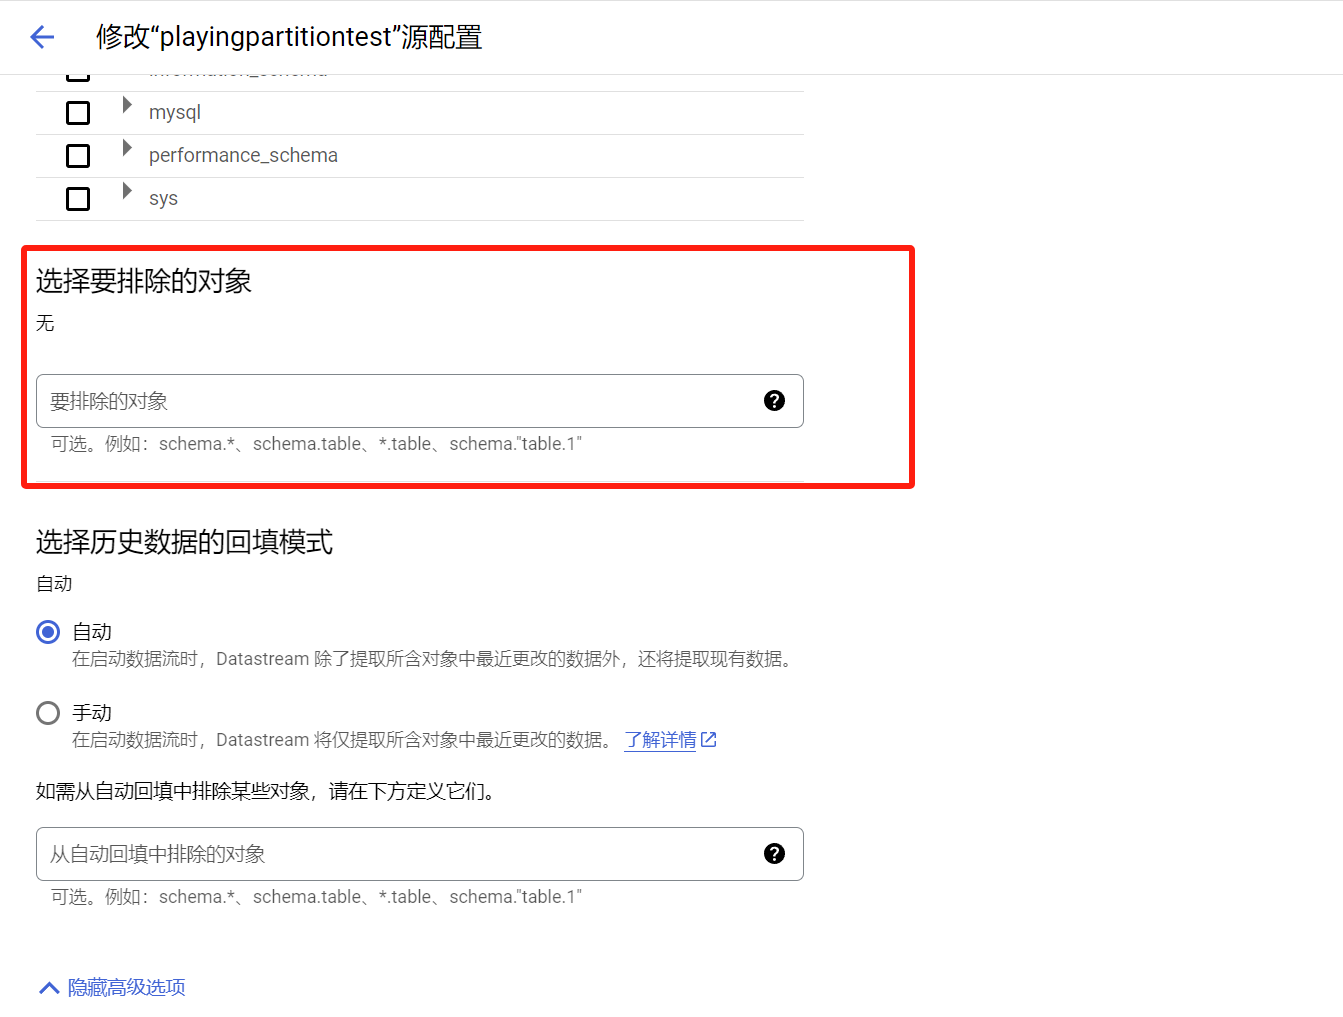

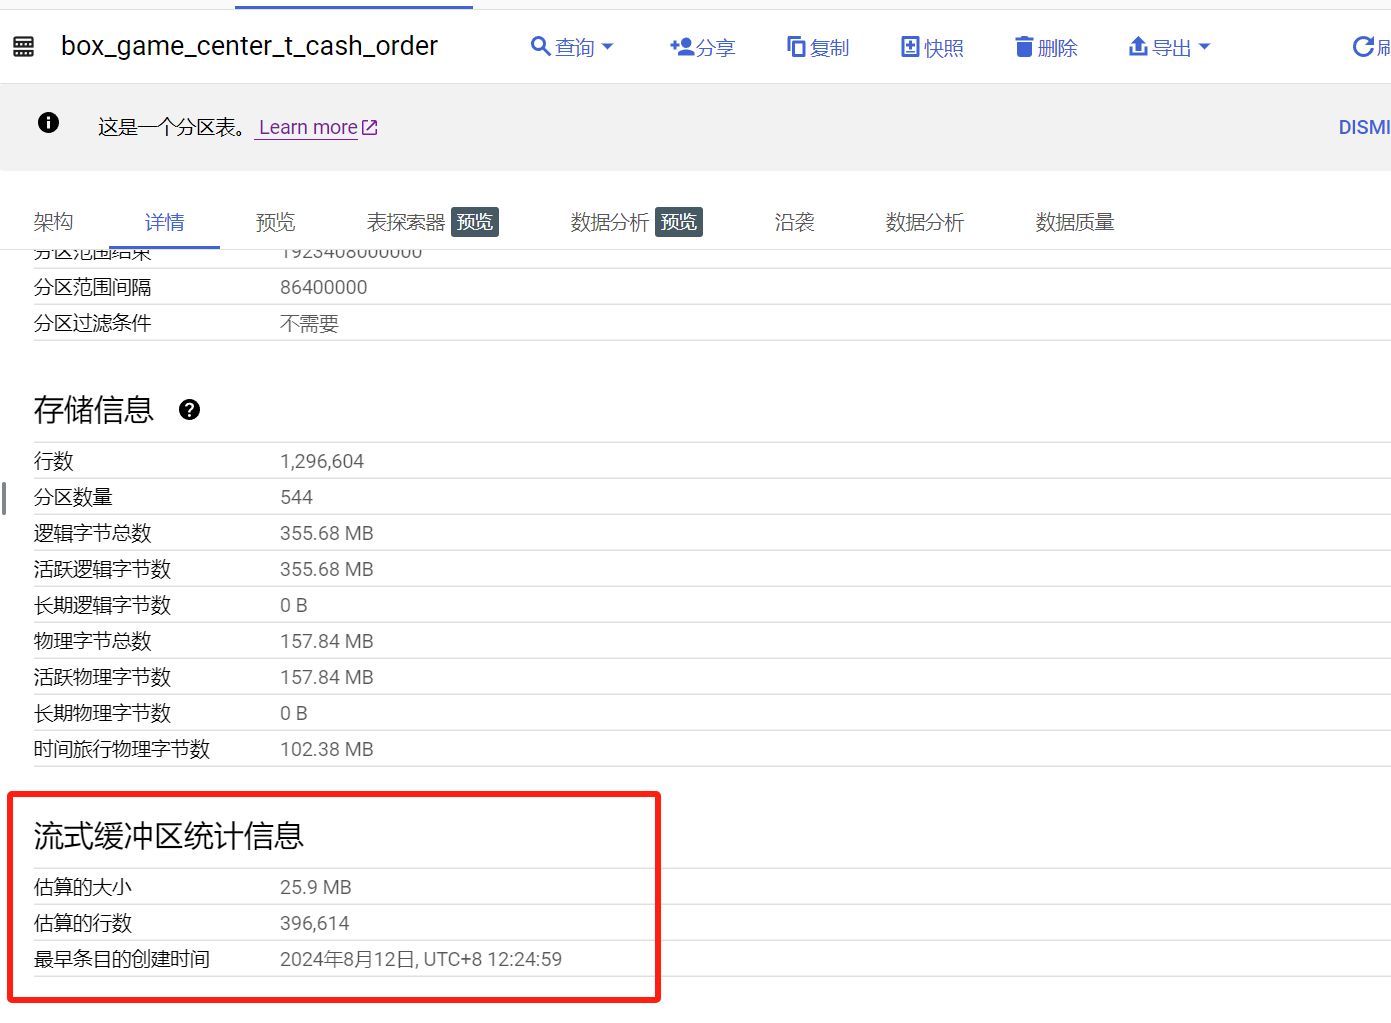

In [6]:
from IPython.display import Image, display
# 图一
image_path = r"D:\1-script\3-PYTHON\image存储jupyter在用的图片存放于此\datastream修改源配置-选中排除对象表.jpg"
display(Image(filename = image_path,width=500, height=500))
# 图二
image_path = r"D:\1-script\3-PYTHON\image存储jupyter在用的图片存放于此\bigquery表详情流式缓冲说明.jpg"
display(Image(filename = image_path,width=500, height=500))

In [ ]:
###### 示例代码1 语句获取方式参考下文 # 2. 表建表语句的快速获取
create or replace table
`hale-ripsaw-362711.playing_datastreamtest.box_game_center_t_cash_order`  
(rid INT64,
orderid STRING,
userid INT64,
amount FLOAT64,
tokenid INT64,
protocol STRING,
src_userid INT64,
src_walletaddress STRING,
dst_walletaddress STRING,
dst_amount FLOAT64,
dst_tokenid INT64,
gas FLOAT64,
exchange_rate FLOAT64,
slippage FLOAT64,
partnerid INT64,
appid INT64,
type INT64,
state INT64,
transactionHash STRING,
reviewmode INT64,
usd_amount FLOAT64,
activity_flag INT64,
platform_id INT64,
detail STRING,
ctime INT64,
rtime INT64,
utime INT64,
datastream_metadata STRUCT<uuid STRING, source_timestamp INT64>,
PRIMARY KEY (orderid,rid) NOT ENFORCED   --此处是注释出主键 不确定是否必须
)
PARTITION BY RANGE_BUCKET(utime, GENERATE_ARRAY(1640995200000, 1923408000000, 86400000))  --整数形态分区 从2022-01-01 到 2030-12-13 一般限定分区的上线为4000个
CLUSTER BY orderid, rid
OPTIONS(
  max_staleness=INTERVAL '0-0 0 1:0:0' YEAR TO SECOND
);

######  二、表相关信息的获取检查
（一）表信息来源       
（二）表建表语句的快速获取 和 设置分区 和 设置 CDC的数据staleness时间   
（三）监控表插入/更新操作的进度      
（四）手动回填的启动     
（五）表分区信息的检查    

###### （一）表信息来源

In [1]:
# 1.1 每个字段代表一个类别信息
# 谷歌参考文档地址：https://cloud.google.com/bigquery/docs/information-schema-partitions?hl=zh-cn
# TABLES：查看表信息。
# TABLE_OPTIONS：查看表设置信息。
# COLUMNS：查看列信息。
# PARTITIONS：查看分区信息。
# SCHEMATA：查看数据集信息。
# JOBS：查看作业信息。

table_information = f'''
SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.{'TABLES'}`
WHERE
  table_name = 'box_game_center_t_cash_order';
'''

print(table_information)


SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.TABLES`
WHERE
  table_name = 'box_game_center_t_cash_order';



###### （二）表建表语句的快速获取 和 设置分区 和 设置 CDC的数据staleness时间 

In [1]:
# 2.1 取INFORMATION_SCHEMA.TABLES查询结果中的字段ddl 
# 谷歌参考文档链接：https://cloud.google.com/bigquery/docs/change-data-capture?hl=zh-cn#monitor_table_upsert_operation_progress
'''
SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.TABLES`
WHERE
  table_name = 'box_game_center_t_cash_order';
'''

# 示例的获取到的语句
'''
CREATE TABLE `hale-ripsaw-362711.playing_datastream.box_game_center_t_cash_order`
(
  ……
  datastream_metadata STRUCT<uuid STRING, source_timestamp INT64>,  --datastream兼容字段
  PRIMARY KEY (orderid, rid) NOT ENFORCED  --指定主键但是不强制去重 表详情页可见
)
CLUSTER BY orderid, rid --以主键执行聚簇
OPTIONS(
  max_staleness=INTERVAL '0-0 0 1:0:0' YEAR TO SECOND
); --CDC Change Date Capture 
   --一种确保数据新鲜度的时间间隔 基本不会超，但是也有极其少数的特殊情况，即你设置的时间短到一次刷新表操作完不成
   --INFORMATION_SCHEMA.TABLES中的upsert_stream_apply_watermark可以确定上次CDC时间 下文详述
'''

# 2.2 基于获取的ddl 修改 
# 修改部分1：聚簇上增加分区
'''
PARTITION BY RANGE_BUCKET(utime, GENERATE_ARRAY(1640995200000, 1923408000000, 86400000))  --整数形态分区 从2022-01-01 到 2030-12-13 一般限定分区的上线为4000个
'''
# 修改部分2：CDC的数据staleness时间 
'''
OPTIONS(
  max_staleness=INTERVAL '0-0 0 1:0:0' YEAR TO SECOND
); 
'''

# 创建表后再次修改CDC的数据staleness时间 如果之前没有这个也可以增加上 同时ddl的语句也会改变
'''
ALTER TABLE `hale-ripsaw-362711.playing_datastreamtest.box_game_center_t_cash_order`
SET OPTIONS (
  max_staleness = INTERVAL 60 MINUTE);
'''

# 检查配置信息 确认staleness时间
'''
SELECT
    *
FROM
    `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.TABLE_OPTIONS`
WHERE
    table_name = 'box_game_center_t_cash_order'
    --and option_name = 'max_staleness'
'''

# 建议max_staleness 取以下两个值中的较大者：
# 工作流的最大可容忍数据过时。
# 将插入/更新的更改应用到表以及一些额外的缓冲区所需的最长时间的两倍。
# 如需计算将插入/更改的更改应用到现有表所需的时间，请使用以下 SQL 查询来确定后台应用作业的第 95 百分位时长，并允许一个七分钟的缓冲区，以允许 BigQuery 写入优化存储空间（流式缓冲区）转换。
'''
SELECT
  project_id,
  destination_table.dataset_id,
  destination_table.table_id,
  APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)] AS p95_background_apply_duration_in_seconds,
  CEILING(APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)]*2/60)+7 AS recommended_max_staleness_with_buffer_in_minutes
FROM `region-us`.INFORMATION_SCHEMA.JOBS AS job
WHERE
  project_id = 'PROJECT_ID'
  AND DATE(creation_time) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND CURRENT_DATE()
  AND job_id LIKE "%cdc_background%"
GROUP BY 1,2,3;
'''

'\nSELECT\n  project_id,\n  destination_table.dataset_id,\n  destination_table.table_id,\n  APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)] AS p95_background_apply_duration_in_seconds,\n  CEILING(APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)]*2/60)+7 AS recommended_max_staleness_with_buffer_in_minutes\nFROM `region-us`.INFORMATION_SCHEMA.JOBS AS job\nWHERE\n  project_id = \'PROJECT_ID\'\n  AND DATE(creation_time) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND CURRENT_DATE()\n  AND job_id LIKE "%cdc_background%"\nGROUP BY 1,2,3;\n'

###### （三）监控表插入/更新操作的进度

In [ ]:
# 3.1 查询 INFORMATION_SCHEMA.TABLES 视图以获取 upsert_stream_apply_watermark 时间戳。 
# 谷歌参考文档链接：https://cloud.google.com/bigquery/docs/change-data-capture?hl=zh-cn#monitor_table_upsert_operation_progress

'''
SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.TABLES`
WHERE
  table_name = 'box_game_center_t_cash_order';
'''

upsert_stream_apply_watermark:
2024-08-12 07:02:42.455837 UTC
2024-08-12 07:54:10.829920 UTC

# 3.2 查询datastream触发的cdc background job
'''
SELECT
*
  -- project_id,
  -- destination_table.dataset_id,
  -- destination_table.table_id,
  -- APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)] AS p95_background_apply_duration_in_seconds,
  -- CEILING(APPROX_QUANTILES((TIMESTAMP_DIFF(end_time, creation_time,MILLISECOND)/1000), 100)[OFFSET(95)]*2/60)+7 AS recommended_max_staleness_with_buffer_in_minutes
FROM `region-us`.INFORMATION_SCHEMA.JOBS AS job
WHERE
  project_id = 'hale-ripsaw-362711'
  AND DATE(creation_time) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY) AND CURRENT_DATE()
  AND job_id LIKE "%cdc_background%"
  AND destination_table.dataset_id = 'playing_datastreamtest'
  AND destination_table.table_id = 'box_game_center_t_cash_order'
order by start_time desc
-- GROUP BY 1,2,3;
'''



###### 3.3 CDC表 真正的刷新时间       
基于上述 ，我们已经知道 三类时间    
（1）我们已经有 upsert_stream_apply_watermark时间     
（2）有 background类型的job在后台处理的时间    
（3）正常查询表是否更新的表详情页面刷新时间    
问题在于到底哪个才是表内数据 真正的刷新时间     
答案是：upsert_stream_apply_watermark时间     
证据是：表内不会有比这个数据更晚的utime      

###### （四）手动回填的启动

谷歌参考文档链接：https://cloud.google.com/datastream/docs/manage-backfill-for-the-objects-of-a-stream?hl=zh-cn    
###### 4.1 手动回填与自动回填差别         
（1）自动回填：Datastream 会将**所有现有数据（数据更改）从来源流式传输到目标位置**。      
如果你配置datastream的时候 选择了自动回填 理论上应该都要回填 但是目前**已知几种情况不会回填**       
a.你自己创建兼容表 让谷歌来传输 不启动回填（存疑 实际情况是我的测试的生产库表已经分片了，可能真的给了全量数据）       
b.数据库勾选时包含未来的表 因为新表通常无数据 不启动回填      
c.你选择了自动回填 但是高级选项中排除了某个表 不启动回填       

（2）手动回填：在启动数据流时，Datastream **将仅提取所含对象中最近更改的数据** 最近范围不确定  可能是binlog保留的时间 比如盘子数据保留是15天       

###### 4.2 如何触发手动回填     
单一数据流详情页面（见下面图一） 选中对象 可查看到**启动回填**和**查看详情**按钮，点击启动回填触发手动回填，详情页面查看状态      
状态有复数种，详细见如下：     
（1）无状态（在界面中表示为 -）：接收此状态的对象的原因包括：       
a.直播尚未开始。        
b.未触发过回填 原因上面说过了           
（2）Pending:对象尚未启动回填。       
（3）Active:对象正在进行回填。      
（4）Completed:对象已完成回填。      
（5）Stopped:，对象已停止回填。如果再次为对象启动回填，则 Datastream 会将与该对象关联的所有现有数据从来源流式传输到目标位置。      
（6）Failed:对象回填失败，必须再次启动回填。         

In [ ]:
-- select 
-- date(timestamp_millis(addTime)),count(1) 
-- from `hale-ripsaw-362711.playing_datastreamtest.box_game_t_game_records` 
-- group by 1
-- order by 1 desc

-- select 
-- date(timestamp_millis(utime)),
-- sum(usd_amount)
-- from `hale-ripsaw-362711.playing_datastreamtest.box_game_center_t_cash_order` 
-- group by 1
-- order by 1 desc


select 
platform_id,
biz_day,
sum(usd_amount)
from fbox_raw.t_order 
--from  `hale-ripsaw-362711.playing_datastream.box_game_center_t_order` 
group by 1,2
order by 1,2 desc


select 
platform_id,
datetime(timestamp_millis(utime)) as biz_day,
sum(usd_amount)
--from fbox_raw.t_order 
from  `hale-ripsaw-362711.playing_datastream.box_game_center_t_order` 
group by 1,2
order by 1,2 desc



select 
a.platform_id,
date(timestamp_millis(a.addTime),'Africa/Casablanca') as biz_day,
count(1)
--from fbox_raw.t_order 
from  `hale-ripsaw-362711.africa365_datastream.box_game_t_game_records` a
join fbox_raw.t_user b on cast(a.uid as string) = b.user_id and cast(a.platform_id as string) = b.platform_id 
where a.platform_id = 13
group by 1,2
order by 1,2 desc

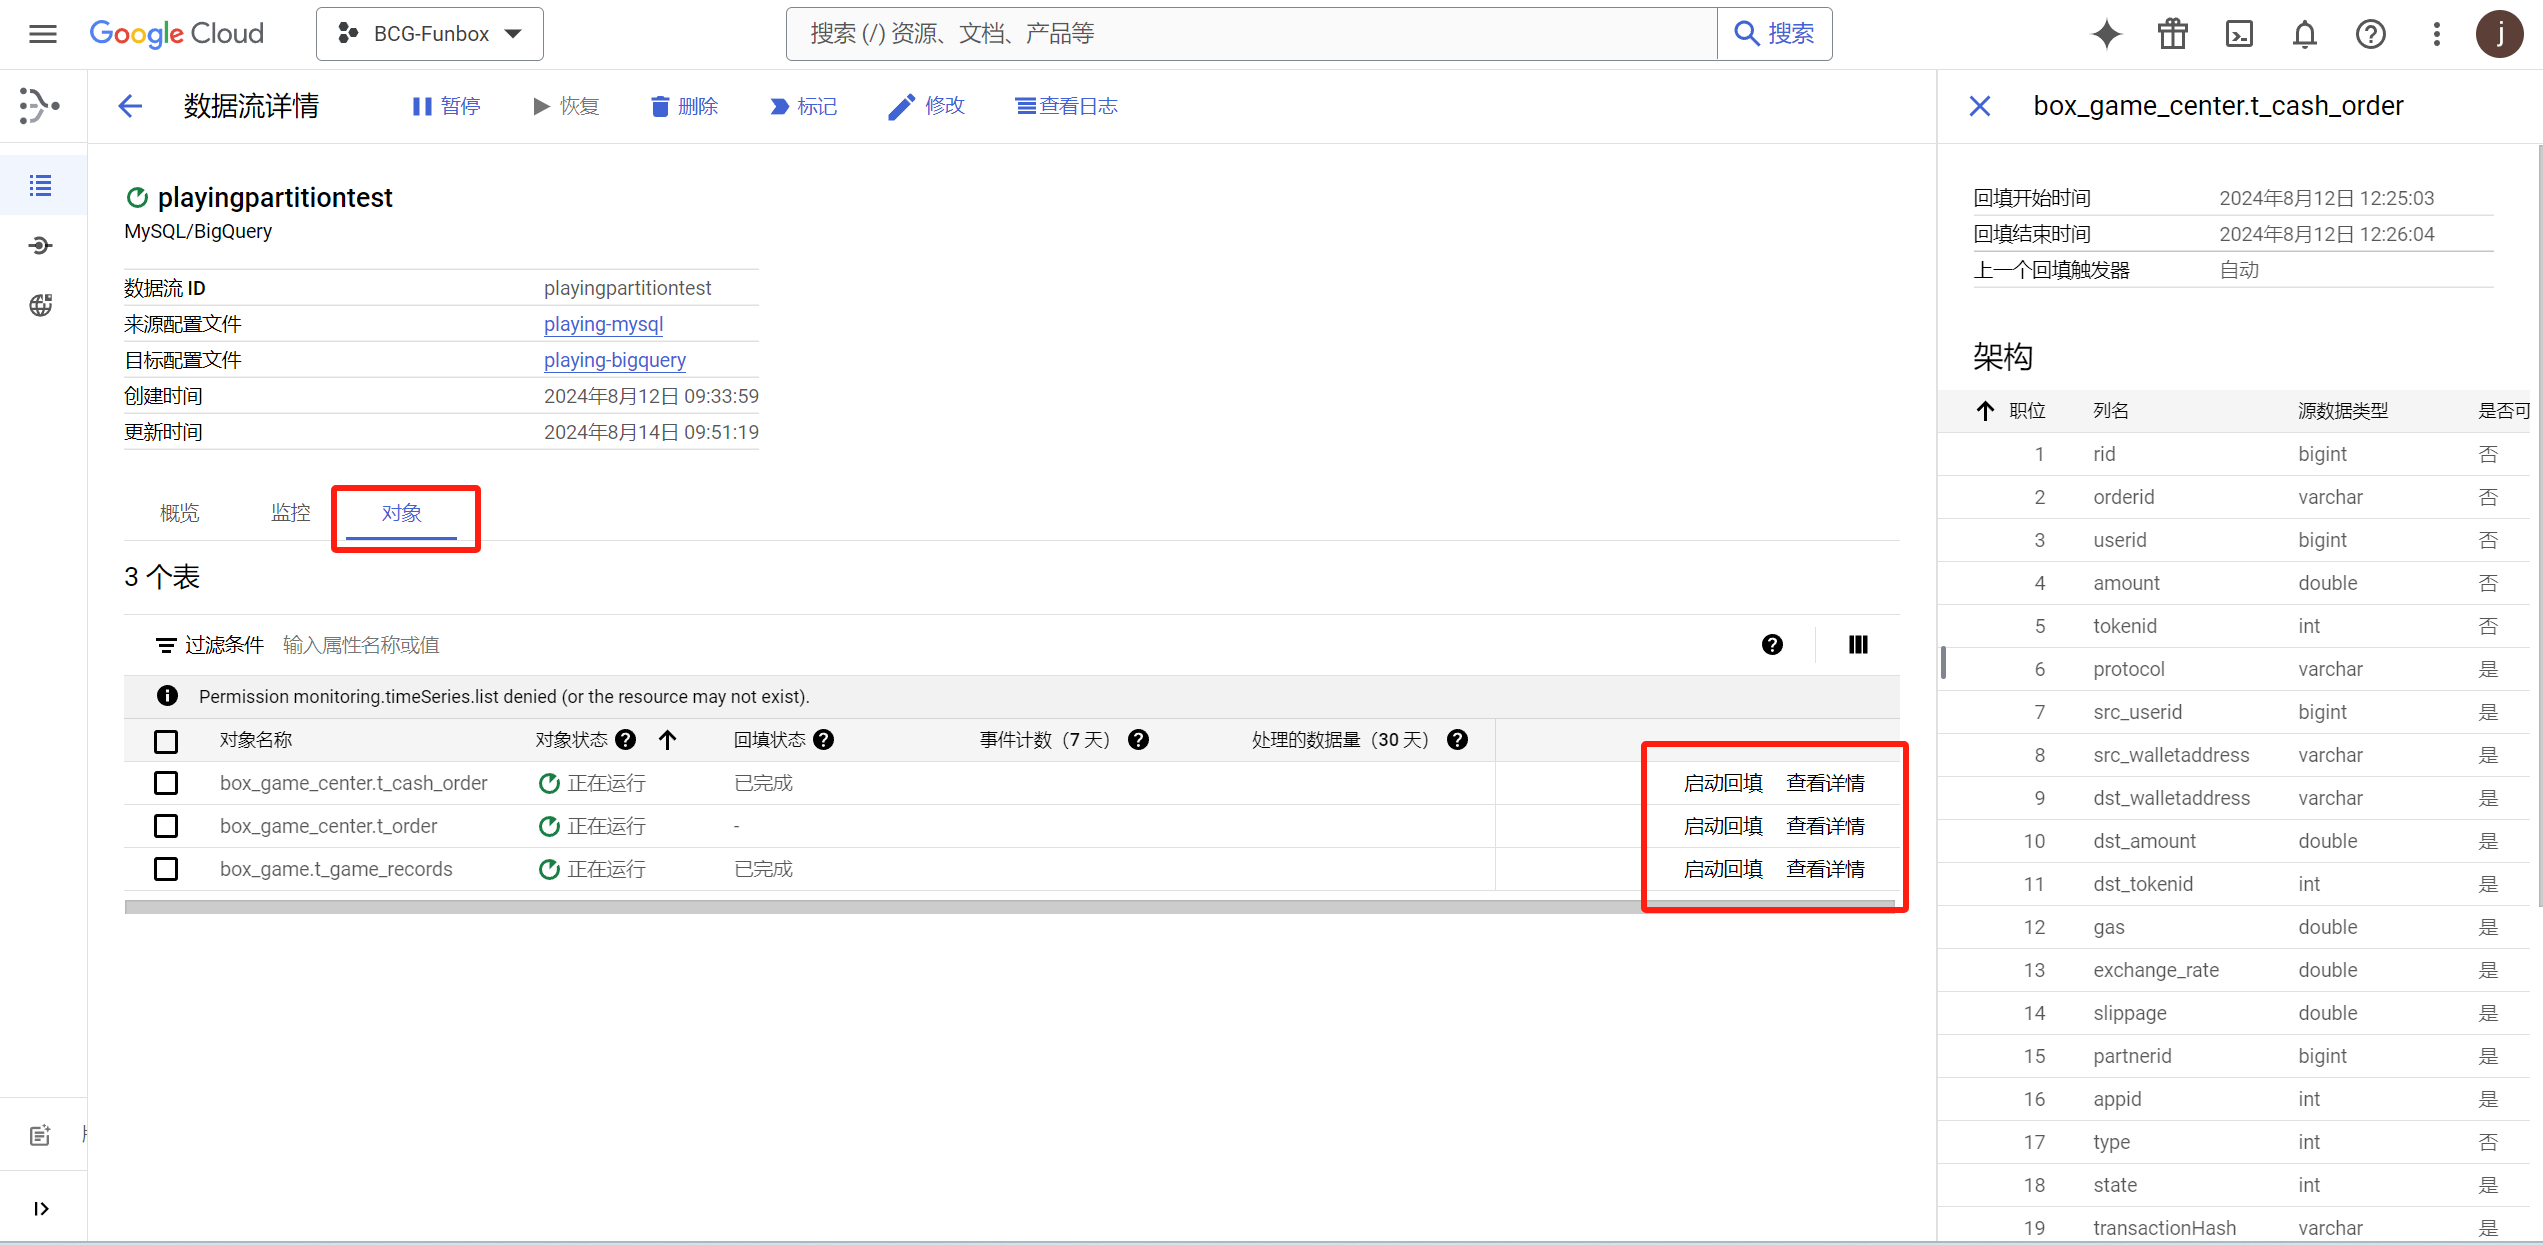

In [18]:
from IPython.display import Image, display
# 图一
image_path = r"D:\1-script\3-PYTHON\image存储jupyter在用的图片存放于此\datastream 手动回填界面展示.jpg"
display(Image(filename = image_path,width=500, height=500))

###### （五）表分区信息的检查

In [16]:
# 5.1 查询 INFORMATION_SCHEMA.PARTITIONS 视图以获取 分区信息 
# 谷歌参考文档链接：https://cloud.google.com/bigquery/docs/information-schema-partitions?hl=zh-cn
'''
SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.PARTITIONS`
WHERE
  table_name = 'box_game_center_t_cash_order';
'''

# 存在无分区的数据行 调取下是否等于表内计数行 等于 表内小于upsert_stream_apply_watermark计数行
## 如果是说明是缓冲的行还未进入表内， 表内的表详情页面的行 ≈ 缓存行+实际表内计数行
### 分区表中缺失分区信息行 
'''
SELECT
*
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.PARTITIONS`
WHERE
  table_name = 'box_game_center_t_cash_order'
  and partition_id = '__UNPARTITIONED__'
'''
### 表内计数行
'''
select count(1) from `hale-ripsaw-362711.playing_datastreamtest.box_game_center_t_cash_order`
'''
### 表内小于upsert_stream_apply_watermark计数行
'''
select count(1) from `hale-ripsaw-362711.playing_datastreamtest.box_game_center_t_cash_order`
where datetime(timestamp_millis(utime)) <(
SELECT
datetime(upsert_stream_apply_watermark)
FROM
  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.TABLES`
WHERE
  table_name = 'box_game_center_t_cash_order'
)
'''

"\nSELECT\n*\nFROM\n  `hale-ripsaw-362711.playing_datastreamtest.INFORMATION_SCHEMA.PARTITIONS`\nWHERE\n  table_name = 'box_game_center_t_cash_order';\n"